In [2]:
%load_ext autoreload
%autoreload 2

#print all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
# from util import *

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Utils

In [17]:
MASS_MUON = 0.105658
MASS_NEUTRON = 0.9395654
MASS_PROTON = 0.938272
MASS_A = 22*MASS_NEUTRON + 18*MASS_PROTON - 0.34381
BE = 0.0295
MASS_Ap = MASS_A - MASS_NEUTRON + BE

In [4]:
def mag2d(x, y):
    return np.sqrt(x**2 + y**2)

In [5]:
def broadcast(v, df):
    for vi, ii in zip(v.index.names, df.index.names):
        if vi != ii:
            raise ValueError("Value index (%s) does not match index (%s)." % (str(vi), str(ii)))
    if len(v.index.names) > len(df.index.names):
        raise ValueError("Value index too long.")
    if len(v.index.names) == len(df.index.names):
        return v

    rpt = df.groupby(level=list(range(v.index.nlevels))).size()
    has_value = v.index.intersection(rpt.index)
    v_rpt = np.repeat(v.loc[has_value].values, rpt)

    return pd.Series(v_rpt, df.index).rename(v.name) 

def multicol_concat(lhs, rhs):
    # Fix the columns
    lhs_col = lhs.columns
    rhs_col = rhs.columns

    nlevel = max(lhs_col.nlevels, rhs_col.nlevels)

    def pad(c):
       return tuple(list(c) + [""]*(nlevel - len(c))) 

    lhs.columns = pd.MultiIndex.from_tuples([pad(c) for c in lhs_col])
    rhs.columns = pd.MultiIndex.from_tuples([pad(c) for c in rhs_col])

    return pd.concat([lhs, rhs], axis=1)

def multicol_add(df, s, **panda_kwargs):
    # if both the series and the df is one level, we can do a simple join()
    if isinstance(s.name, str) and df.columns.nlevels == 1:
        return df.join(s, **panda_kwargs)

    if isinstance(s.name, str):
        s.name = (s.name,)

    nlevel = max(df.columns.nlevels, len(s.name))
    def pad(c):
       return tuple(list(c) + [""]*(nlevel - len(c))) 

    if df.columns.nlevels < nlevel:
        df.columns = pd.MultiIndex.from_tuples([pad(c) for c in df.columns])
    if len(s.name) < nlevel:
        s.name = pad(s.name)

    return df.join(s, **panda_kwargs)

def multicol_merge(lhs, rhs, **panda_kwargs):
    # Fix the columns
    lhs_col = lhs.columns
    rhs_col = rhs.columns

    nlevel = max(lhs_col.nlevels, rhs_col.nlevels)

    def pad(c):
       nc = 1 if isinstance(c, str) else len(c)
       c0 = [c] if isinstance(c, str) else list(c)
       return tuple(c0 + [""]*(nlevel - nc)) 

    lhs.columns = pd.MultiIndex.from_tuples([pad(c) for c in lhs_col])
    rhs.columns = pd.MultiIndex.from_tuples([pad(c) for c in rhs_col])

    return lhs.merge(rhs, **panda_kwargs)

def detect_vectors(tree, branch):
    ret = []
    hierarchy = branch.split(".")
    for i in range(len(hierarchy)):
        subbranch = ".".join(hierarchy[:i+1])
        lenbranch = subbranch + "..length"
        if lenbranch in tree.keys():
            ret.append(subbranch)
    return ret

def idarray(ids, lens):
    return np.repeat(ids.values, lens.values)

def loadbranches(tree, branches, **uprargs):
    vectors = []
    for i,branch in enumerate(branches):
        this_vectors = detect_vectors(tree, branch)
        if i == 0:
            vectors = this_vectors
        elif len(this_vectors) == 0: # This case is ok since it will automatically broadcast
            pass
        # All the branches must have the same vector structure for this to work
        elif vectors != this_vectors:
            raise ValueError("Branches %s and %s have different vector structures in the CAF." % (branches[0], branch))

    lengths = [tree.arrays([v+"..length"], library="pd", **uprargs) for v in vectors]
    data = tree.arrays(branches, library="pd", **uprargs)

    # If there's no vectors, we can just return the top guy
    if len(lengths) == 0:
        data.index.name = "entry"
        df = data
    else:
        tomerge = lengths + [data]
        # Otherwise, iteratively merge the branches
        df = tomerge[0]
        df.index.name = "entry"

        # handle the rest
        for i in range(1, len(tomerge)):
            thismerge = tomerge[i]
            v_ind = i - 1

            # Build the information in the right-hand table needed to do the join
            # The "upidx" will be matched to the index vector-by-vector
            for i in range(v_ind):
                thismerge[vectors[v_ind] + "..upidx" + str(i)] = idarray(df[vectors[i]+ "..index"], df[vectors[v_ind] + "..length"])

            # Inner join! Throw away rows in the right-hand with no match in the left-hand
            df = pd.merge(df, thismerge, how="inner",
                         left_on = ["entry"] + [v+"..index" for v in vectors[:v_ind]],
                         right_on = ["entry"] + [vectors[v_ind] + "..upidx" + str(i) for i in range(v_ind)],
                         validate="one_to_many")

            # Make sure no rows in the right-hand were dropped
            assert(df.shape[0] == thismerge.shape[0])

            # postprocess: build the index
            df[vectors[v_ind] + "..index"] = df.groupby(["entry"] + [v+"..index" for v in vectors[:v_ind]]).cumcount()

        # Set the index
        df.set_index([v+"..index" for v in vectors], append=True, verify_integrity=True, inplace=True)

        # Drop all the metadata info we don't need anymore
        df = df[branches]

    # Setup branch names so df reflects structure of CAF file
    bsplit = [b.split(".") for b in branches]
    # Replace any reserved names
    def unreserve(s):
        if s == "index":
            return "idx"
        if s[0].isdigit(): # make the name a legal field 
            return "I" + s
        return s

    bsplit = [[unreserve(s) for s in b] for b in bsplit]

    depth = max([len(b) for b in bsplit])

    def pad(b):
        return tuple(b + [""]*(depth - len(b)))

    df.columns = pd.MultiIndex.from_tuples([pad(b) for b in bsplit])

    return df

In [6]:
def issignal(df):
    # return InFV(df.position, 50) & (df.iscc) & (df.nmu == 1) & (df.np == 1)
    return (df.iscc) & (df.nmu == 1) & (df.np == 1)

In [7]:
def InFV(data): # cm
    xmin = -199.15 + 10
    ymin = -200. + 10
    zmin = 0.0 + 10
    xmax = 199.15 - 10
    ymax =  200. - 10
    zmax =  500. - 50
    return (data.x > xmin) & (data.x < xmax) & (data.y > ymin) & (data.y < ymax) & (data.z > zmin) & (data.z < zmax)

def InBeam(t):
    return (t > 0.) & (t < 1.800)

In [8]:
def is_cosmic(df):
    return (df.slc.truth.pdg == -1)

def is_FV(df): 
    return (InFV(df.position))

def is_numu(df):
    return (np.abs(df.pdg) == 14)

def is_CC(df):
    return (df.iscc == 1)

def is_NC(df):
    return (df.iscc == 0)

def is_1p0pi(df):
    return (df.nmu_20MeV == 1) & (df.np_50MeV == 1) & (df.npi_40MeV == 0) & (df.npi0 == 0) 

def is_signal(df):
    return is_numu(df) & is_CC(df) & is_1p0pi(df) & is_FV(df)

def is_outFV(df):
    return is_numu(df) & is_CC(df) & is_1p0pi(df) & np.invert(is_FV(df))

def is_othernumuCC(df):
    return is_numu(df) & is_CC(df) & np.invert(is_1p0pi(df)) & is_FV(df)

# Plotters

In [9]:
mode_list = [0, 10, 1, 2, 3]
mode_labels = ['QE', 'MEC', 'RES', 'SIS/DIS', 'COH', "other"]
mode_colors = ["darkorchid", "royalblue", "forestgreen", "darkorange", "firebrick"]

def breakdown_mode(var, df):
    ret = [var[df.genie_mode == i] for i in mode_list] 
    return ret


In [10]:
top_labels = ["Signal",
              "Other numu CC",
              "NC",
              "Out of FV",
              "Cosmic",
              "Other"]

def breakdown_top(var, df):
    ret = [var[is_signal(df)],
           var[is_othernumuCC(df)],
           var[is_NC(df)],
           var[is_outFV(df)],
           var[is_cosmic(df)],
           var[np.invert(is_signal(df) | is_othernumuCC(df) | is_NC(df) | is_outFV(df) | is_cosmic(df))]
           ]
    return ret

# Make SBND eventdf

In [ ]:
fname = "/exp/sbnd/data/users/munjung/osc/sbnd_gump.df"
# fname = "/exp/sbnd/data/users/munjung/sbnd_gump.df"
# fname_icarus = "/exp/sbnd/data/users/gputnam/gump.df"

with pd.HDFStore(fname) as store:
    print(store.keys())

In [ ]:
mcdf = pd.read_hdf(fname, "mcnu")
slcdf = pd.read_hdf(fname, "slc_trk")

In [ ]:
mcdf

In [ ]:
slcdf

## PID Info

In [ ]:
# PID

# use trackscore
ts_cut = (slcdf.pfp.trackScore > 0.5)

pid_shw = np.invert(ts_cut)

# muon
MUSEL_MUSCORE_TH = 25
MUSEL_PSCORE_TH = 100
MUSEL_LEN_TH = 50

# TODO: use average over planes
# muon_chi2 = (Avg(df, "muon", drop_0=True) < MUSEL_MUSCORE_TH) & (Avg(df, "proton", drop_0=True) > MUSEL_PSCORE_TH)

# TODO: used BDT scores
# len_cut = (masterdf.len.squeeze() > MUSEL_LEN_TH)
# dazzle_muon = (masterdf.dazzle.muonScore > 0.6)
# muon_cut = (muon_chi2) & (len_cut | dazzle_muon)

mu_score_cut = (slcdf.pfp.trk.chi2pid.I2.chi2_muon < MUSEL_MUSCORE_TH) & \
    (slcdf.pfp.trk.chi2pid.I2.chi2_proton > MUSEL_PSCORE_TH)
mu_len_cut = (slcdf.pfp.trk.len > MUSEL_LEN_TH)
mu_cut = (mu_score_cut) & (mu_len_cut)
pid_mu = (ts_cut) & (mu_cut)

# proton 
PSEL_MUSCORE_TH = 0
PSEL_PSCORE_TH = 90
p_score_cut = (slcdf.pfp.trk.chi2pid.I2.chi2_muon > PSEL_MUSCORE_TH) & (slcdf.pfp.trk.chi2pid.I2.chi2_muon < PSEL_PSCORE_TH) 
p_cut = np.invert(mu_cut) & p_score_cut
pid_p = (ts_cut) & (p_cut)

# rest is pion
pi_cut = np.invert(mu_cut | p_cut)
pid_pi = (ts_cut) & (pi_cut)

# TODO: don't use trackscore

# ---------------------------

# store PID info
slcdf[("pfp", "pid", "", "", "", "")] = np.nan
slcdf.loc[pid_shw, ("pfp","pid")] = -1
slcdf.loc[pid_mu, ("pfp","pid")] = 13
slcdf.loc[pid_p, ("pfp","pid")] = 2212
slcdf.loc[pid_pi, ("pfp","pid")] = 211

In [ ]:
pid_mu = (slcdf.pfp.pid == 13)
truth_mu = (np.abs(slcdf.pfp.trk.truth.p.pdg) == 13)

pid_p = (slcdf.pfp.pid == 2212)
truth_p = (np.abs(slcdf.pfp.trk.truth.p.pdg) == 2212)

pid_pi = (slcdf.pfp.pid == 211)
truth_pi = (np.abs(slcdf.pfp.trk.truth.p.pdg) == 211)

In [ ]:
var = slcdf.pfp.trk.chi2pid.I2.chi2_muon
pvar = [var[truth_mu], var[truth_p], var[truth_pi]]
plt.hist(pvar, bins=np.linspace(0,80,101), histtype='step', 
         label=['muon', 'proton', 'pion'], density=True)
plt.axvline(MUSEL_MUSCORE_TH, color='r', label="MUSEL")
plt.axvline(PSEL_MUSCORE_TH, color='b', label="PSEL")
plt.xlabel("Muon Score")
plt.legend()
plt.show();

var = slcdf.pfp.trk.chi2pid.I2.chi2_proton
pvar = [var[truth_mu], var[truth_p], var[truth_pi]]
plt.hist(pvar, bins=np.linspace(0,200,101), histtype='step', 
         label=['muon', 'proton', 'pion'], density=True)
plt.axvline(MUSEL_PSCORE_TH, color='r', label="MUSEL")
plt.axvline(PSEL_PSCORE_TH, color='b', label="PSEL")
plt.xlabel("Proton Score")
plt.legend()
plt.show();

In [ ]:
var = slcdf.pfp.trk.len
pvar = [var[pid_mu & truth_mu], var[pid_mu & truth_p], var[pid_mu & truth_pi]]
plt.hist(pvar, bins=np.linspace(0,400,21), histtype="step",
         label=["muon", "proton", "pion"])

print("muon selection purity {:.2f} %".format(100*len(var[pid_mu & truth_mu])/len(var[pid_mu])))
plt.legend()
plt.show();

var = slcdf.pfp.trk.len
pvar = [var[truth_mu & pid_mu], var[truth_mu & pid_p], var[truth_mu & pid_pi]]
plt.hist(pvar, bins=np.linspace(0,400,21), histtype="step",
         label=["muon", "proton", "pion"])

print("muon selection efficiency {:.2f} %".format(100*len(var[pid_mu & truth_mu])/len(var[truth_mu])))
plt.legend()
plt.show();

In [ ]:
slcdf[("pfp", "trk", "is_contained", "", "", "")] = (InFV(slcdf.pfp.trk.start)) & (InFV(slcdf.pfp.trk.end))

slcdf[("pfp", "trk", "P", "p_muon", "", "")] = np.nan
slcdf.loc[slcdf.pfp.trk.is_contained, ("pfp", "trk", "P", "p_muon", "", "")]  = slcdf.loc[(slcdf.pfp.trk.is_contained), ("pfp", "trk", "rangeP", "p_muon", "", "")]
slcdf.loc[np.invert(slcdf.pfp.trk.is_contained), ("pfp", "trk", "P", "p_muon","", "")] = slcdf.loc[np.invert(slcdf.pfp.trk.is_contained), ("pfp", "trk", "mcsP", "fwdP_muon", "", "")]

slcdf[("pfp", "trk", "P", "p_pion", "", "")] = np.nan
slcdf.loc[slcdf.pfp.trk.is_contained, ("pfp", "trk", "P", "p_pion", "", "")]  = slcdf.loc[(slcdf.pfp.trk.is_contained), ("pfp", "trk", "rangeP", "p_pion", "", "")]
slcdf.loc[np.invert(slcdf.pfp.trk.is_contained), ("pfp", "trk", "P", "p_pion", "", "")] = slcdf.loc[np.invert(slcdf.pfp.trk.is_contained), ("pfp", "trk", "mcsP", "fwdP_pion", "", "")]

slcdf[("pfp", "trk", "P", "p_proton", "", "")] = np.nan
slcdf.loc[slcdf.pfp.trk.is_contained, ("pfp", "trk", "P", "p_proton", "", "")]  = slcdf.loc[(slcdf.pfp.trk.is_contained), ("pfp", "trk", "rangeP", "p_proton", "", "")]
slcdf.loc[np.invert(slcdf.pfp.trk.is_contained), ("pfp", "trk", "P", "p_proton", "", "")] = slcdf.loc[np.invert(slcdf.pfp.trk.is_contained), ("pfp", "trk", "mcsP", "fwdP_proton", "", "")]

In [ ]:
slcdf[("pfp", "trk", "cos", "x", "", "")] = np.nan
slcdf[("pfp", "trk", "cos", "x", "", "")] = (slcdf.pfp.trk.end.x-slcdf.pfp.trk.start.x)/slcdf.pfp.trk.len
slcdf[("pfp", "trk", "cos", "y", "", "")] = np.nan
slcdf[("pfp", "trk", "cos", "y", "", "")] = (slcdf.pfp.trk.end.y-slcdf.pfp.trk.start.y)/slcdf.pfp.trk.len
slcdf[("pfp", "trk", "cos", "z", "", "")] = np.nan
slcdf[("pfp", "trk", "cos", "z", "", "")] = (slcdf.pfp.trk.end.z-slcdf.pfp.trk.start.z)/slcdf.pfp.trk.len

In [ ]:
mudf = slcdf[(slcdf.pfp.pid == 13)].sort_values(slcdf.pfp.index.names[:-1] + [("pfp", "trk", "len", "", "", "")]).groupby(level=[0,1,2]).last()
mudf.columns = pd.MultiIndex.from_tuples([tuple(["mu"] + list(c)) for c in mudf.columns])

pdf = slcdf[(slcdf.pfp.pid == 2212)].sort_values(slcdf.pfp.index.names[:-1] + [("pfp", "trk", "len", "", "", "")]).groupby(level=[0,1,2]).last()
pdf.columns = pd.MultiIndex.from_tuples([tuple(["p"] + list(c)) for c in pdf.columns])

slcdf = multicol_merge(slcdf, mudf, left_index=True, right_index=True, how="left", validate="one_to_one")
slcdf = multicol_merge(slcdf, pdf, left_index=True, right_index=True, how="left", validate="one_to_one")

# in case we want to cut out other objects -- save the highest energy of each other particle
lead_shw_length = slcdf.pfp.trk.len[(slcdf.pfp.pid < 0)].groupby(level=[0,1,2]).max().rename("lead_shw_length")
slcdf = multicol_add(slcdf, lead_shw_length)

lead_pion_length = slcdf.pfp.trk.len[(slcdf.pfp.pid == 211)].groupby(level=[0,1,2]).max().rename("lead_pion_length")
slcdf = multicol_add(slcdf, lead_pion_length)

subl_muon_length = slcdf[(slcdf.pfp.pid == 13)].sort_values(slcdf.pfp.index.names[:-1] + [("pfp", "trk", "len", "", "", "")]).pfp.trk.len.groupby(level=[0,1,2]).nth(-2).rename("subl_muon_length")
slcdf = multicol_add(slcdf, subl_muon_length)

subl_proton_length = slcdf[(slcdf.pfp.pid == 2212)].sort_values(slcdf.pfp.index.names[:-1] + [("pfp", "trk", "len", "", "", "")]).pfp.trk.len.groupby(level=[0,1,2]).nth(-2).rename("subl_proton_length")
slcdf = multicol_add(slcdf, subl_proton_length)

## Truth Match

In [ ]:
# truth match

bad_tmatch = np.invert(slcdf.slc.tmatch.eff > 0.5) & (slcdf.slc.tmatch.idx >= 0)
slcdf.loc[bad_tmatch, ("slc","tmatch","idx", "", "", "", "")] = np.nan

# match # of column levels
mcdf.columns = pd.MultiIndex.from_tuples([tuple(list(c) +["", "", "", ""]) for c in mcdf.columns])

df = pd.merge(slcdf.reset_index(), 
              mcdf.reset_index(),
              left_on=[("__ntuple", "", "",), 
                       ("entry", "", "",), 
                       ("slc", "tmatch", "idx")], 
              right_on=[("__ntuple", "", ""), 
                        ("entry", "", ""), 
                        ("rec.mc.nu..index", "", "")], 
              how="left"
              ) 

df = df.set_index(slcdf.index.names, verify_integrity=True)

In [ ]:
df

# Selection

In [18]:
df = pd.read_hdf("/exp/sbnd/data/users/munjung/osc/sbnd_gump_evtdf.df", "evtdf")

In [19]:
df

slc  \
                                                      is_clear_cosmic   
                                                                        
                                                                        
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index rec.slc.reco.pfp..index                   
0        0     0              0                                     0   
                              2                                     0   
                              3                                     0   
         1     0              0                                     0   
                              1                                     0   
..                                                                ...   
1642     158   2              0                                     0   
         159   0              0                                     0   
               2              0                                     0   
                              1                                     0   
                              2                                     0   

                                                                               \
                                                           vertex               
                                                                x           y   
                                                                                
                                                                                
                                                                                
                                                                                
__ntuple entry rec.slc..index rec.slc.reco.pfp..index                           
0        0     0              0                         13.283050   43.480118   
                              2                         13.283050   43.480118   
                              3                         13.283050   43.480118   
         1     0              0                        106.960251  -44.493328   
                              1                        106.960251  -44.493328   
..                                                            ...         ...   
1642     158   2              0                        -38.514679  -87.111877   
         159   0              0                       -117.544678 -162.252792   
               2              0                         52.806805 -109.327377   
                              1                         52.806805 -109.327377   
                              2                         52.806805 -109.327377   

                                                                        \
                                                                  self   
                                                                z        
                                                                         
                                                                         
                                                                         
                                                                         
__ntuple entry rec.slc..index rec.slc.reco.pfp..index                    
0        0     0              0                        117.108307   31   
                              2                        117.108307   31   
                              3                        117.108307   31   
         1     0              0                         48.070827   23   
                              1                         48.070827   23   
..                                                            ...  ...   
1642     158   2              0                        378.389343   25   
         159   0            

In [20]:
# vertex in FV

df = df[InFV(df.slc.vertex)]

In [21]:
# cosmic rejection 

# var = [df.slc.nu_score[is_cosmic(df)],
#        df.slc.nu_score[np.invert(is_cosmic(df))]]
# plt.hist(var, bins=21, label=["Cosmic", "Nu"], histtype="step", density=True)
# plt.legend()
# plt.show();

# Traditional 
# nu_score = (df.slc.nu_score > 0.5)
# f_match = (df.slc.fmatch.score < 7.0) & (InBeam(df.slc.fmatch.time))
# cosmic_rejection = nu_score & f_match

# CRUMBS
# crumbs = (df.slc_crumbs_result.score > 0)
# cosmic_rejection = (crumbs)

# df = df[cosmic_rejection]

In [22]:
# has one muon, one proton, no pion, no shower
# df = df[~np.isnan(df.mu.pfp.pid) & ~np.isnan(df.p.pfp.pid) & np.isnan(df.lead_pion_length) & np.isnan(df.lead_shw_length) & np.isnan(df.subl_muon_length) & np.isnan(df.subl_proton_length)]

# has one contained muon, one contained proton, no pion, no shower
df = df[df.mu.pfp.trk.is_contained & df.p.pfp.trk.is_contained & np.isnan(df.lead_pion_length) & np.isnan(df.lead_shw_length) & np.isnan(df.subl_muon_length) & np.isnan(df.subl_proton_length)]

signal purity 70.14 %


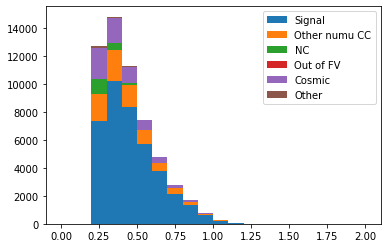

In [23]:
var = df.mu.pfp.trk.P.p_muon
pvar = breakdown_top(var, df)
n, bins, _ = plt.hist(pvar, bins=np.linspace(0,2,21), stacked=True, 
                      label=top_labels)
print("signal purity {:.2f} %".format(100*n[0].sum()/n[-1].sum()))
plt.legend()
plt.show();

In [24]:
# TODO: save to df in makedf?
# Caculate transverse kinematics

mu_p = df.mu.pfp.trk.P.p_muon
mu_p_x = mu_p * df.mu.pfp.trk.cos.x
mu_p_y = mu_p * df.mu.pfp.trk.cos.y
mu_p_z = mu_p * df.mu.pfp.trk.cos.z
mu_phi_x = mu_p_x/mag2d(mu_p_x, mu_p_y)
mu_phi_y = mu_p_y/mag2d(mu_p_x, mu_p_y)

p_p = df.p.pfp.trk.P.p_proton
p_p_x = p_p * df.p.pfp.trk.cos.x
p_p_y = p_p * df.p.pfp.trk.cos.y
p_p_z = p_p * df.p.pfp.trk.cos.z
p_phi_x = p_p_x/mag2d(p_p_x, p_p_y)
p_phi_y = p_p_y/mag2d(p_p_x, p_p_y)

mu_Tp_x = mu_phi_y*mu_p_x - mu_phi_x*mu_p_y
mu_Tp_y = mu_phi_x*mu_p_x - mu_phi_y*mu_p_y
mu_Tp = mag2d(mu_Tp_x, mu_Tp_y)

p_Tp_x = mu_phi_y*p_p_x - mu_phi_x*p_p_y
p_Tp_y = mu_phi_x*p_p_x - mu_phi_y*p_p_y
p_Tp = mag2d(p_Tp_x, p_Tp_y)

del_Tp_x = mu_Tp_x + p_Tp_x
del_Tp_y = mu_Tp_y + p_Tp_y
del_Tp = mag2d(del_Tp_x, del_Tp_y)

del_alpha = np.arccos(-(mu_Tp_x*del_Tp_x + mu_Tp_y*del_Tp_y)/(mu_Tp*del_Tp))
del_theta = np.arccos(-(mu_Tp_x*p_Tp_x + mu_Tp_y*p_Tp_y)/(mu_Tp*p_Tp))

mu_E = mag2d(mu_p, MASS_MUON)
p_E = mag2d(p_p, MASS_PROTON)

R = MASS_A + mu_p_z + p_p_z - mu_E - p_E
del_Lp = 0.5*R - mag2d(MASS_Ap, del_Tp)**2/(2*R)
del_p = mag2d(del_Tp, del_Lp)

In [25]:
DELP_TH = 0.25

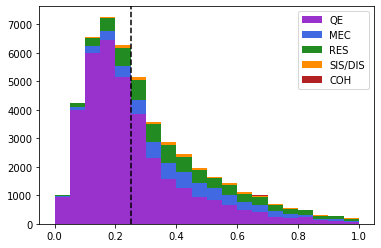

In [26]:
var = breakdown_mode(del_p, df)
n, bins, _ = plt.hist(var, bins=np.linspace(0,1,21), stacked=True, 
                      label=mode_labels, color=mode_colors)
plt.axvline(DELP_TH, color='k', linestyle="--")
plt.legend()
plt.show();

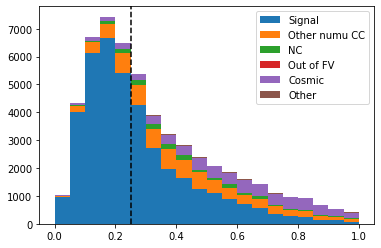

In [27]:
var = del_p
pvar = breakdown_top(var, df)
n, bins, _ = plt.hist(pvar, bins=np.linspace(0,1,21), stacked=True, 
                      label=top_labels)
plt.axvline(DELP_TH, color='k', linestyle="--")
plt.legend()
plt.show();

In [28]:
# transverse momentum cut
df = df[del_p < DELP_TH]

signal purity 89.32 %


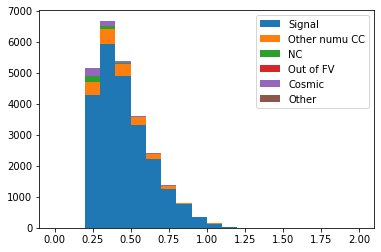

In [29]:
var = df.mu.pfp.trk.P.p_muon
pvar = breakdown_top(var, df)
n, bins, _ = plt.hist(pvar, bins=np.linspace(0,2,21), stacked=True, 
                      label=top_labels)
print("signal purity {:.2f} %".format(100*n[0].sum()/n[-1].sum()))
plt.legend()
plt.show();